In [12]:
import textwrap
import warnings
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from transformers import pipeline
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

warnings.filterwarnings('ignore')

# ZSC Model

In [13]:
zs_classifier = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [14]:
zs_classifier(
            "This is a great movie", 
            candidate_labels=["positive", "negative"]
            )

{'sequence': 'This is a great movie',
 'labels': ['positive', 'negative'],
 'scores': [0.9969461560249329, 0.003053826978430152]}

In [15]:
zs_classifier(
            "This is a great movie", 
            candidate_labels=["english", "french", "german", "spanish"]
            )

{'sequence': 'This is a great movie',
 'labels': ['english', 'french', 'spanish', 'german'],
 'scores': [0.3948880434036255,
  0.2653058171272278,
  0.18184597790241241,
  0.15796007215976715]}

### Apply on BBC Dataset

In [16]:
df_bbc = pd.read_csv("data/bbc_text_cls.csv")
df_bbc.text = df_bbc.text.str.replace(r"\s+", " ")
df_bbc.head()

,text,labels
0,Ad sales boost Time Warner profit Quarterly pr...,business
1,Dollar gains on Greenspan speech The dollar ha...,business
2,Yukos unit buyer faces loan claim The owners o...,business
3,High fuel prices hit BA's profits British Airw...,business
4,Pernod takeover talk lifts Domecq Shares in UK...,business


In [17]:
all_labels = df_bbc.labels.unique().tolist()
all_labels

['business', 'entertainment', 'politics', 'sport', 'tech']

In [28]:
all_texts = df_bbc.text.tolist()

assert 'cuda' in str(zs_classifier.device), "Please set the device to GPU"

preds = zs_classifier(
                    all_texts, 
                    candidate_labels=all_labels
                    )

In [31]:
max_score_idxs = [np.argmax(pred['scores']) for pred in preds]
pred_labels = [pred['labels'][idx] for idx, pred in zip(max_score_idxs, preds)]

# Evaluation

### F1 Score

In [32]:
f1_score(df_bbc.labels, pred_labels, average='macro')

0.6038169874143356

### Confusion Matrix

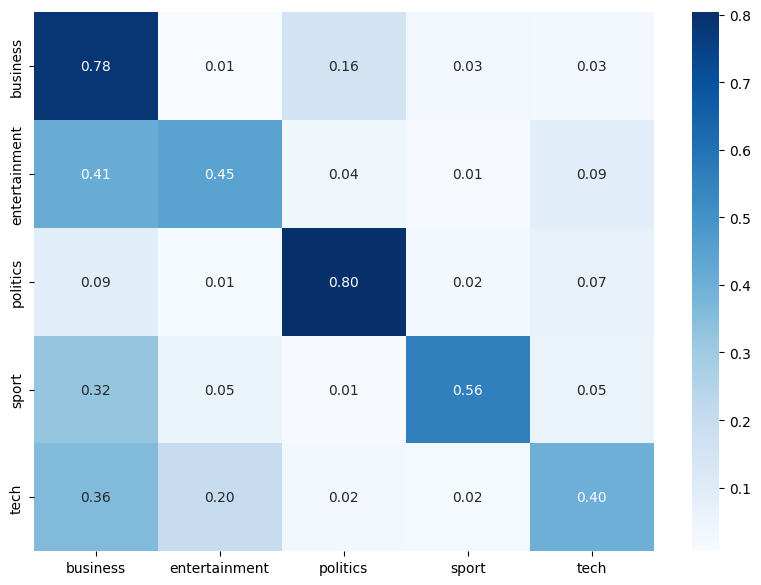

In [33]:
cm = confusion_matrix(df_bbc.labels, pred_labels, labels=all_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=all_labels, columns=all_labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues')
plt.show()